In [186]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

### Data Pre Processing

#### Load Data

In [187]:
df = pd.read_csv("../processed_ds/solar/solar_fl/solar_fl.csv")

In [188]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Get the list of directories (sites)
files = os.listdir('../processed_ds/solar/')
files = [f for f in files if os.path.isdir('../processed_ds/solar/' + f)]
files.sort()  # Sort the site directories

# Initialize empty lists for train and test data
train_dfs = []
test_dfs = []

# Iterate over the site directories
for f in files:
    site_files = os.listdir(f'../processed_ds/solar/{f}')
    site_files = [sf for sf in site_files if sf.endswith('.csv')]
    site_files.sort()

    # Process each file in the site
    for sf in site_files:
        file_path = f'../processed_ds/solar/{f}/{sf}'
        df_site = pd.read_csv(file_path)

        # Add a site identifier column
        df_site['solar'] = str(f.split('_')[1])

        # Perform 80-20 train-test split on time order
        train_size = int(0.8 * len(df_site))
        df_train = df_site.iloc[:train_size]  # First 80% as training data
        df_test = df_site.iloc[train_size:]  # Remaining 20% as test data 

        # Append to lists
        train_dfs.append(df_train)
        test_dfs.append(df_test)

# Concatenate all train and test data separately
train_df = pd.concat(train_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)

# Save if needed
train_df.to_csv('../processed_ds/solar/train_data.csv', index=False)
test_df.to_csv('../processed_ds/solar/test_data.csv', index=False)

# Print summary
print(f"Total Train Samples: {len(train_df)}")
print(f"Total Test Samples: {len(test_df)}")

Total Train Samples: 504576
Total Test Samples: 126144


In [138]:
train_df = pd.read_csv('../processed_ds/solar/train_data.csv')
test_df = pd.read_csv('../processed_ds/solar/test_data.csv')


In [189]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
label_encoder = LabelEncoder()

# Apply encoding
train_df['solar'] = label_encoder.fit_transform(train_df['solar'])
test_df['solar'] = label_encoder.transform(test_df['solar'])

In [190]:
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols.remove('solar')  # Exclude categorical column

train_df[num_cols] = (train_df[num_cols] - train_df[num_cols].mean()) / (train_df[num_cols].std() + 1e-8)
test_df[num_cols] = (test_df[num_cols] - test_df[num_cols].mean()) / (test_df[num_cols].std() + 1e-8)

# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# df = scaler.fit_transform(df)

# df = pd.DataFrame(df)

In [191]:
train_df = train_df.drop(columns=['date'])
test_df = test_df.drop(columns=['date'])

In [192]:
train_df.head()

,loc-1,loc-2,loc-3,loc-4,loc-5,loc-6,loc-7,loc-8,loc-9,OT,solar
0,-0.548539,-0.620866,-0.432267,-0.4832,-0.612569,-0.548046,-0.619053,-0.595619,-0.551157,-0.50242,0
1,-0.548539,-0.620866,-0.432267,-0.4832,-0.612569,-0.548046,-0.619053,-0.595619,-0.551157,-0.50242,0
2,-0.548539,-0.620866,-0.432267,-0.4832,-0.612569,-0.548046,-0.619053,-0.595619,-0.551157,-0.50242,0
3,-0.548539,-0.620866,-0.432267,-0.4832,-0.612569,-0.548046,-0.619053,-0.595619,-0.551157,-0.50242,0
4,-0.548539,-0.620866,-0.432267,-0.4832,-0.612569,-0.548046,-0.619053,-0.595619,-0.551157,-0.50242,0


In [193]:
def df_to_X_y(df, target_col=10, window_size=32, horizon=16):
    df_as_np = df.to_numpy()
    X, y = [], []

    for i in range(len(df_as_np) - window_size - horizon + 1):  # Adjust to avoid out-of-bounds
        # Select past 'window_size' rows as features
        X.append(df_as_np[i:i + window_size])

        # Select the next 'horizon' future values for target column
        y.append(df_as_np[i + window_size:i + window_size + horizon, target_col])  

    return np.array(X), np.array(y)


In [194]:
# Process Train Data
X_train, y_train = df_to_X_y(train_df, target_col=9)  # Use correct target column

# Process Test Data
X_test, y_test = df_to_X_y(test_df, target_col=9)  # Same column index

#### Rough Tests

In [148]:
X_train.shape

(504529, 32, 11)

#### Train Test Split

### Model Preparation

In [195]:
class LSTMModel(nn.Module):
    def __init__(self,
                 num_tasks,
                 num_features,
                 time_window,
                 output_window,
                 num_labels,
                 num_layers=2,
                 hidden_size=16):
        super(LSTMModel, self).__init__()

        self.output_window = output_window
        self.num_labels = num_labels
        self.dual = False

        self.intermediary = False

        self.lstm = nn.LSTM(num_features,
                            hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=0.2)
        self.fc = nn.Linear(hidden_size, num_labels * output_window)

    def forward(self, x):
        B, T, D = x.shape  # Fix: Remove x[0], should be x
        # h0 = torch.zeros(2, B, 16).to(x.device)
        # c0 = torch.zeros(2, B, 16).to(x.device)
        x_, _ = self.lstm(x)
        # Select the last time step's hidden state (most recent information)
        last_hidden = x_[:, -1, :]  # Shape: (B, hidden_size)

        # Fully connected layer
        x_ = self.fc(last_hidden)  # Shape: (B, num_labels * output_window)

        # Reshape to (B, output_window, num_labels)
        x_ = x_.reshape(B, self.output_window, self.num_labels)

        return x_

In [196]:
# Hyperparameters
SEQ_LEN = 32  # Input window length
HORIZON = 16  # Prediction horizon
NUM_FEATURES = 11 # Input features (e.g., PM2.5, NO2)
NUM_LABELS = 1  # Predict same number of labels

# Instantiate model
model = LSTMModel(
    num_tasks=1,  # Only 1 task
    num_features=NUM_FEATURES,
    time_window=SEQ_LEN,
    output_window=HORIZON,
    num_labels=NUM_LABELS,
    num_layers=2,
    hidden_size=16 # Increased hidden size
)
model.to("cuda")

LSTMModel(
  (lstm): LSTM(11, 16, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=16, out_features=16, bias=True)
)

In [210]:
def train_model(model, train_loader, num_epochs=20, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    device = "cuda"

    for epoch in range(num_epochs):
        print("EPOCH: ", epoch)
        model.train(True)
        running_loss = 0.0
        
        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            y_batch = y_batch.unsqueeze(-1)

            output = model(x_batch)

            loss = criterion(output, y_batch)
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

In [211]:
# Convert to PyTorch tensors
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

In [215]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to('cpu'), batch[1].to('cpu')
    print(y_batch)
    break

tensor([[-0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024,
         -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024],
        [-0.3131, -0.2981, -0.2782, -0.2732, -0.2632, -0.2832, -0.2832, -0.2931,
         -0.2832, -0.2832, -0.2931, -0.3081, -0.3131, -0.2533, -0.2782, -0.2084],
        [-0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024,
         -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024],
        [ 0.6039,  0.6687,  0.5690,  0.6537,  0.7036,  0.5541,  0.5989,  0.7883,
          0.7384,  0.7833,  0.7982,  0.8780,  0.8730,  0.7933,  0.7384,  0.7085],
        [-0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024,
         -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024],
        [-0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024,
         -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024, -0.5024],
        [-0.5024, -0.5

### Model Training

In [213]:
train_model(model, train_loader, num_epochs=30, lr=1e-3)

EPOCH:  0
Epoch 1, Loss: 0.0743
EPOCH:  1
Epoch 2, Loss: 0.0604
EPOCH:  2
Epoch 3, Loss: 0.0572
EPOCH:  3
Epoch 4, Loss: 0.0555
EPOCH:  4
Epoch 5, Loss: 0.0541
EPOCH:  5
Epoch 6, Loss: 0.0528
EPOCH:  6
Epoch 7, Loss: 0.0518
EPOCH:  7
Epoch 8, Loss: 0.0509
EPOCH:  8
Epoch 9, Loss: 0.0504
EPOCH:  9
Epoch 10, Loss: 0.0497
EPOCH:  10
Epoch 11, Loss: 0.0492
EPOCH:  11
Epoch 12, Loss: 0.0487
EPOCH:  12
Epoch 13, Loss: 0.0482
EPOCH:  13
Epoch 14, Loss: 0.0479
EPOCH:  14
Epoch 15, Loss: 0.0475
EPOCH:  15


KeyboardInterrupt: 

### Model Evaluation

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    mae_list = []
    criterion = nn.L1Loss()
    
    all_predictions = []
    all_actuals = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")
    
            predictions = model(batch_x)
            
            # Compute MAE for each horizon step
            mae = criterion(predictions, batch_y.unsqueeze(-1)).item()
            mae_list.append(mae)
            
            # Move tensors to CPU and convert to numpy for plotting
            all_predictions.append(predictions.cpu().numpy())
            all_actuals.append(batch_y.cpu().numpy())
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_actuals = np.concatenate(all_actuals, axis=0)

    return np.mean(mae_list), all_predictions, all_actuals  # Average MAE across batches

mae, predictions, actuals = evaluate_model(model, test_loader)
print(f"Mean Absolute Error (MAE) across horizon: {mae:.4f}")

Mean Absolute Error (MAE) across horizon: 0.1425


### Plotting Predicton

In [182]:
actuals

array([[[-0.40124717],
        [-0.40124717],
        [-0.40124717],
        ...,
        [-0.40124717],
        [-0.40124717],
        [-0.40124717]],

       [[-0.40124717],
        [-0.40124717],
        [-0.40124717],
        ...,
        [-0.40124717],
        [-0.40124717],
        [-0.40124717]],

       [[-0.40124717],
        [-0.40124717],
        [-0.40124717],
        ...,
        [-0.40124717],
        [-0.40124717],
        [-0.40124717]],

       ...,

       [[-0.40124717],
        [-0.40124717],
        [-0.40124717],
        ...,
        [-0.40124717],
        [-0.40124717],
        [-0.40124717]],

       [[-0.40124717],
        [-0.40124717],
        [-0.40124717],
        ...,
        [-0.40124717],
        [-0.40124717],
        [-0.40124717]],

       [[-0.40124717],
        [-0.40124717],
        [-0.40124717],
        ...,
        [-0.40124717],
        [-0.40124717],
        [-0.40124717]]], dtype=float32)

In [184]:
predictions[0]

array([[-0.46015012],
       [-0.44488716],
       [-0.42732775],
       [-0.41728348],
       [-0.40786237],
       [-0.40072072],
       [-0.39042944],
       [-0.38553476],
       [-0.3772251 ],
       [-0.3735345 ],
       [-0.36469644],
       [-0.35711628],
       [-0.35465264],
       [-0.35081536],
       [-0.34908932],
       [-0.3414815 ]], dtype=float32)

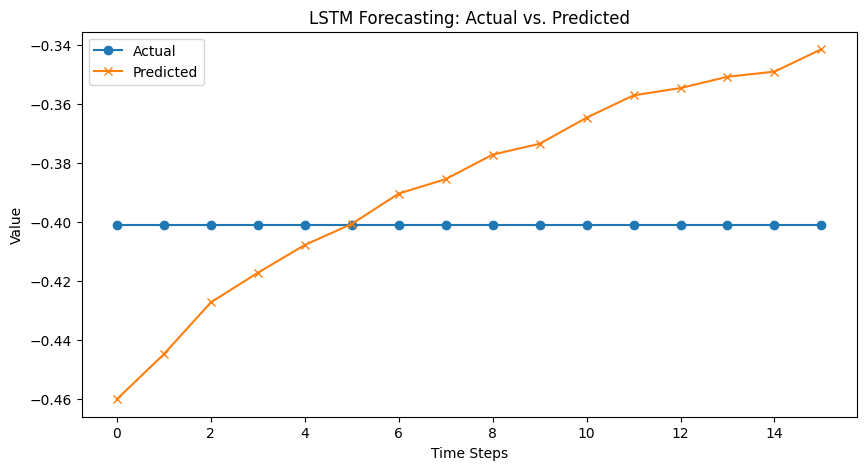

In [180]:
def plot_predictions(actuals, predictions, sample_idx=0, horizon=16):
    plt.figure(figsize=(10, 5))
    
    actual = actuals[sample_idx]  # Shape (horizon,)
    pred = predictions[sample_idx]  # Shape (horizon,)

    # Plot actual values
    plt.plot(range(len(actual)), actual, label="Actual", marker="o")

    # Plot predicted values
    plt.plot(range(len(pred)), pred, label="Predicted", marker="x")

    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.title("LSTM Forecasting: Actual vs. Predicted")
    plt.legend()
    plt.show()

# Plot for first sample in test set
plot_predictions(actuals, predictions, sample_idx=2, horizon=HORIZON)